> Interactive online version: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1mTh6_YEgCRl6DAKqnmRp2XMOW8CTCvm7?usp=sharing)

# Quickstart

In this notebook you will learn the basics of using `p-winds` to model the upper atmosphere (up to many planetary radii) of a H/He-dominated planet, and to compute the steady-state ionization balance of H.

`p-winds` is largely based on the theoretical framework of [Oklopčić & Hirata (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...855L..11O/abstract) and [Lampón et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020A%26A...636A..13L/abstract), which themselves based their work on the stellar wind model of [Parker (1958)](https://ui.adsabs.harvard.edu/abs/1958ApJ...128..664P/abstract).

**Notice**: `p-winds` is not suitable for simulations of the lower atmosphere (above $\sim 10^{-7}$ bar). Also, this page is a Jupyter notebook, and you can download it [here](https://raw.githubusercontent.com/ladsantos/p-winds/main/docs/source/quickstart.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import astropy.units as u
import astropy.constants as c
from p_winds import tools, parker, hydrogen, helium

# Uncomment the next line if you have a MacBook with retina screen
# %config InlineBackend.figure_format = 'retina'
pylab.rcParams['figure.figsize'] = 9.0,6.5
pylab.rcParams['font.size'] = 18

Let's start by retrieving the planetary and stellar parameters of HD 209458 b. Depending on your versions of `astropy` and `astroquery`, you may get some warnings from those packages. You may also get warnings from `p-winds` asking you to give some attention to a "bad" parameter.

In [2]:
hd209b_params, hd209_params = tools.fetch_planet_system('HD 209458 b')

/Users/leonardo/GitHub/p-winds/p_winds/tools.py:85: Warning: Planetary parameter 'semi_major_axis' of HD 209458 b requires your attention.
  warn("Planetary parameter '{}' of {} requires your "


In my case I got a warning saying that the planetary parameter `'semi_major_axis'` of HD 209458 b requires my attention. So let's set its value manually.

We will assume that our planet has an isothermal upper atmosphere with temperature of $9 \times 10^3$ K and a total mass loss rate of $8 \times 10^{10}$ g s$^{-1}$ based on the results from [Salz et al. 2016](https://ui.adsabs.harvard.edu/abs/2016A%26A...586A..75S/abstract). We will also assume a H vs. He fraction (in number of atoms) of $0.9$, and an average ion fraction of $0.7$.

In [3]:
# HD 209458 b
R_pl = hd209b_params['radius'][0].to(u.jupiterRad).value  # Planetary radius
M_pl = hd209b_params['mass'][0].to(u.jupiterMass).value  # Planetary mass
a_pl = 0.04707  # Semi-major axis in au
m_dot = 8E10  # Planetary mass loss rate (assumed) in g/s
T_0 = 9E3  # Atmospheric temperature (assumed) in K
d_st = hd209_params['distance'][0].to(u.pc).value  # Stellar distance
h_he = 0.9  # H/He fraction (assumed)
mean_f_ion = 0.7  # Mean ionization fraction (assumed)

The next step is to calculate the structure of the planetary atmosphere in terms of densities and velocities.

**Note**: `p-winds` requires the use of `astropy.Quantity` for some of its inputs to avoid errors due to unit conversion. Furthermore, some of the quantities that the code calculates are in "convenience units" to avoid numerical overflows (e.g., velocities and densities calculated by `parker.structure()` are measured in units of sound speed and density at the sonic point, respectively).

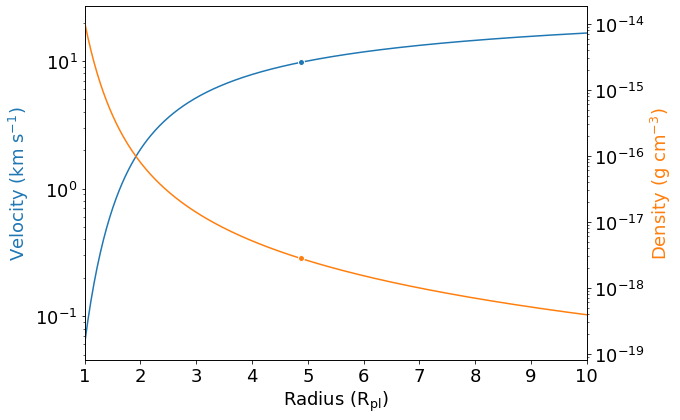

In [4]:
vs = parker.sound_speed(T_0, h_he, mean_f_ion)  # Speed of sound (km/s, assumed to be constant)
rs = parker.radius_sonic_point(M_pl, vs)  # Radius at the sonic point (jupiterRad)
rhos = parker.density_sonic_point(m_dot, rs, vs)  # Density at the sonic point (g/cm^3)

# The `parker.structure()` function requires us to pass values of radius in units of 
# radius at the sonic point (`rs`). So, first we build an `r_array` from 1 to 15 
# planetary radii, than change its unit to `rs`
r_array = np.linspace(1, 15, 500) * R_pl / rs
v_array, rho_array = parker.structure(r_array)

# Convenience arrays for the plots
r_plot = r_array * rs / R_pl
v_plot = v_array * vs
rho_plot = rho_array * rhos

# Finally plot the structure of the upper atmosphere
# The circles mark the velocity and density at the sonic point
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.semilogy(r_plot, v_plot, color='C0')
ax1.plot(rs / R_pl, vs, marker='o', markeredgecolor='w', color='C0')
ax2.semilogy(r_plot, rho_plot, color='C1')
ax2.plot(rs / R_pl, rhos, marker='o', markeredgecolor='w', color='C1')
ax1.set_xlabel(r'Radius (R$_{\rm pl}$)')
ax1.set_ylabel(r'Velocity (km s$^{-1}$)', color='C0')
ax2.set_ylabel(r'Density (g cm$^{-3}$)', color='C1')
ax1.set_xlim(1, 10)
plt.show()

The next step is to calculate the steady-state distribution of H (neutral or ionized) in the atmosphere. To do that, first we need to retrieve the high-energy spectrum of the host star with fluxes at the planet. For convenience, there is a text file in the `data` folder of the `p-winds` package containing the spectrum arriving at HD 209458 b (`HD209458b_spectrum_lambda.dat`). This spectrum was retrieved from the [X-exoplanets](http://sdc.cab.inta-csic.es/xexoplanets/jsp/homepage.jsp) database, the unit of energy was changed from photons to erg, and the flux scaled to the semi-major axis of HD 209458 b. But, for now, we shall instead use the solar spectrum, because it covers all the wavelengths important for the helium steady-state.

There is a convenience method in `tools.make_spectrum_from_file()` that takes text files as input for the spectrum and transforms it into a `dict` that can be used as input for our calculations.

**Note**: We will see below that it is also possible to make calculations without the need of input spectra, but we will need monochromatic fluxes in the X-rays + extreme ultraviolet (0-911 Å and 0-504 Å) and far- to middle-ultraviolet (911-2600 Å).

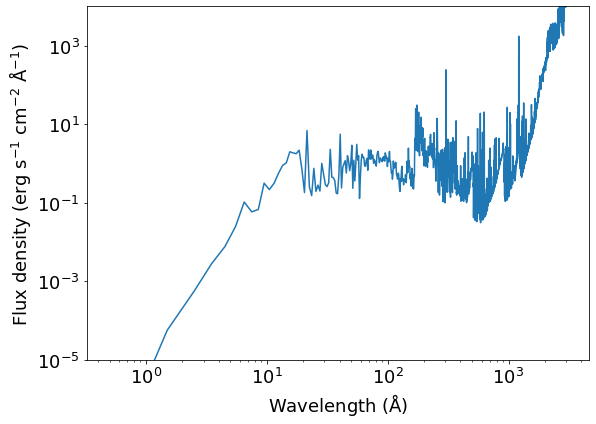

In [5]:
units = {'wavelength': u.angstrom, 'flux': u.erg / u.s / u.cm ** 2 / u.angstrom}
spectrum = tools.make_spectrum_from_file('../../data/solar_spectrum_scaled_lambda.dat',
                                    units)
plt.loglog(spectrum['wavelength'], spectrum['flux_lambda'])
plt.ylim(1E-5, 1E4)
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel(r'Flux density (erg s$^{-1}$ cm$^{-2}$ ${\rm \AA}^{-1}$)')
plt.show()

Finally, we can calculate the distribution of ionized/neutral hydrogen. This involves calculating the differential equation 13 in [Oklopčić & Hirata (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...855L..11O/abstract). To achieve this, we start from an initial state at the innermost layer of the atmosphere and utilize the `hydrogen.ion_fraction()` function. It takes as input many of the parameters we already set above. 

One thing that you may want to change is the `initial_f_ion` of the integration, which is an optional parameter. The initial state is the `y0` of the differential equation to be solved. This array has the initial value of `f_ion` (ionization fraction) at the surface of the planet. The standard value for this parameter is `0.0`, i.e., completely neutral near the surface.

In [6]:
# We compute `f_ion` from 1 to 15 planetary radii
r = np.linspace(1.0, 20, 500)
initial_f_ion = 0.0

f_r = hydrogen.ion_fraction(r, R_pl, T_0, h_he, 
                            m_dot, M_pl, mean_f_ion,
                            spectrum_at_planet=spectrum,
                            initial_f_ion=initial_f_ion)

And now we plot the result.

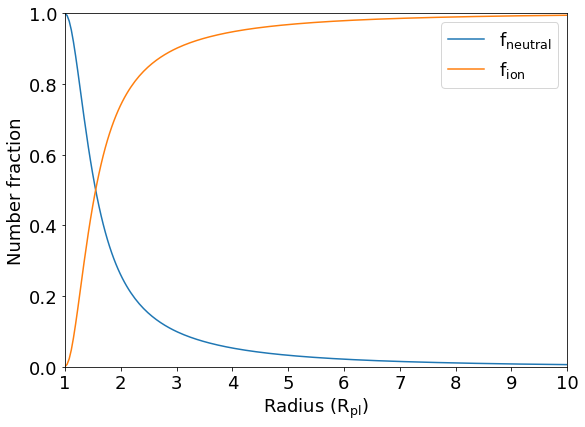

In [7]:
f_ion = f_r
f_neutral = 1 - f_r

plt.plot(r, f_neutral, color='C0', label='f$_\mathrm{neutral}$')
plt.plot(r, f_ion, color='C1', label='f$_\mathrm{ion}$')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number fraction')
plt.xlim(1, 10)
plt.ylim(0, 1)
plt.legend()
plt.show()

In the next step, we calculate the population of helium in singlet, triplet and ionized states using `helium.population_fraction()`. Similar to the hydrogen module, we integrate starting from the outer layer of the atmosphere. Also, in this module we change the absolute and relative numerical tolerances of the integrator so it doesn't lose precision. This is necessary because, in some cases, the fractions of singlet and triplet state can differ by a few orders of magnitude, and since everything is solved at the same time, the solver can easily lose precision.

In [8]:
atol = 1E-8  # Absolute numerical tolerance for the solver
rtol = 1E-8  # Relative numerical tolerance

# In the initial state, the fraction of singlet and triplet helium is 1E-6, and the optical depths are null
initial_state = np.array([0.5, 0.5])
f_he_1, f_he_3 = helium.population_fraction(
    r, R_pl, T_0, h_he, m_dot, M_pl, f_ion, spectrum,
    initial_state=initial_state, atol=atol, rtol=rtol)

TypeError: population_fraction() missing 2 required positional arguments: 'radius_sonic_point' and 'density_sonic_point'

Finally, we plot the number densities of ionized helium, and helium in singlet and triplet states.

In [ ]:
# Hydrogen atom mass
m_h = c.m_p.to(u.g).value

# Number density of helium nuclei
n_he = (rho_array * rhos * (1 - h_he) / (1 + 4 * (1 - h_he)) / m_h)

n_he_1 = f_he_1 * n_he
n_he_3 = f_he_3 * n_he
n_he_ion = (1 - f_he_1 - f_he_3) * n_he

plt.semilogy(r, n_he_1, color='C0', label='He singlet')
plt.semilogy(r, n_he_3, color='C1', label='He triplet')
plt.semilogy(r, n_he_ion, color='C2', label='He ionized')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number density (cm$^{-3}$)')
plt.xlim(1, 10)
plt.ylim(1E-2, 1E10)
plt.legend()
plt.show()

In case you don't have an input spectrum handy, you can also calculate ionization fractions of H and the He population using monochromatic fluxes at specific wavelength channels. The results will probably be a bit different from the ones calculated with a spectrum. Based on the solar spectrum arriving at HD 209458 b, a reasonable estimate of these fluxes is:

$f_{504} = 500$ erg/s/cm$^2$ (wavelength range to ionize He singlet, 0 - 504 Å)

$f_{911} = 1000$ erg/s/cm$^2$ (wavelength range to ionize H, 0 - 911 Å)

$f_\mathrm{uv} = 5 \times 10^6$ erg/s/cm$^2$ (wavelength range to ionize He triplet, 911 - 2593 Å)

In [ ]:
f504 = 500 #* u.erg / u.s / u.cm ** 2
f911 = 1000 #* u.erg / u.s / u.cm ** 2
fuv = 5E6 #* u.erg / u.s / u.cm ** 2

# We compute `f_ion` from 1 to 15 planetary radii
r = np.linspace(1.0, 20, 500)
initial_f_ion = 0.0

f_r = hydrogen.ion_fraction(r, R_pl, T_0, h_he, 
                            m_dot, M_pl, mean_f_ion,
                            flux_euv=f911,
                            initial_f_ion=initial_f_ion)

f_ion = f_r
f_neutral = 1 - f_r

plt.plot(r, f_neutral, color='C0', label='f$_\mathrm{neutral}$')
plt.plot(r, f_ion, color='C1', label='f$_\mathrm{ion}$')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('H number fraction')
plt.xlim(1, 10)
plt.ylim(0, 1)
plt.legend()
plt.show()

Finally, we calculate the helium population with the monocromatic fluxes.

In [ ]:
atol = 1E-8  # Absolute numerical tolerance for the solver
rtol = 1E-8  # Relative numerical tolerance

# In the initial state, the fraction of singlet and triplet helium is 1E-6, and the optical depths are null
initial_state = np.array([1.0, 0.0])
f_he_1, f_he_3 = helium.population_fraction(
    r, R_pl, T_0, h_he, m_dot, M_pl, f_ion, flux_euv=f504, flux_fuv=fuv,
    initial_state=initial_state, atol=atol, rtol=rtol)

# Number density of helium nuclei
n_he = (rho_array * rhos * (1 - h_he) / (1 + 4 * (1 - h_he)) / m_h)

n_he_1 = f_he_1 * n_he
n_he_3 = f_he_3 * n_he
n_he_ion = (1 - f_he_1 - f_he_3) * n_he

plt.semilogy(r, n_he_1, color='C0', label='He singlet')
plt.semilogy(r, n_he_3, color='C1', label='He triplet')
plt.semilogy(r, n_he_ion, color='C2', label='He ionized')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number density (cm$^{-3}$)')
plt.xlim(1, 10)
plt.ylim(1E-2, 1E10)
plt.legend()
plt.show()